Testing filtering of stop words in dataset. To do this we can use the python natural language toolkit: https://www.nltk.org/

In [1]:
import nltk
from nltk.corpus import stopwords
import string
import unicodedata
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jikael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jikael/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/jikael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')

In [3]:
df['topic pass 2'].unique()

array(['Political Attack and Accusations', 'Social Issues',
       'Media and Public Engagement', 'Economic and Financial Issues',
       'Elections and Political Strategies', 'Domestic Policy',
       'Foreign Policy and National Security',
       'Scandals and Controversies', nan], dtype=object)

In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/vance.tsv', sep='\t')
df['valid'] = df['description'].map(lambda x: type(x) == str)
df=df[df['valid']]
df['topic'] = np.random.randint(0,9, size=len(df))

In [8]:
df.iloc()[1]['description']

"Sen. JD Vance, who says running as Trump's VP pick has cost him friends, is wrapping up his by asking voters to not let political differences come between them."

In [60]:
from nltk.tokenize import TweetTokenizer # use this one because the other one struggles with words like "don't"

def filter_sentence(sentence, stop_words, tokenizer):
    word_tokens = tokenizer.tokenize(sentence)
    word_tokens = filter(lambda x: len(x) > 1 and x != '...', word_tokens) # removes all punctuation/symbols found by tokenizer
    filtered_sentence = ' '.join([w for w in word_tokens if (not w.lower() in stop_words)]) # remove stop words
    return filtered_sentence

In [61]:
def pre_process_descriptions(df):
    stop_words = set(stopwords.words('english'))
    tokenizer = TweetTokenizer()
    df['description_processed'] = df['description'].map(lambda x: filter_sentence(x, stop_words, tokenizer))

In [62]:
pre_process_descriptions(df)

In [64]:
def get_corpus_by_category(df):
  corpus_dict = dict()
  for topic in df.topic.unique():
    filtered_df = df[df.topic == topic]
    sentence = ' '.join(filtered_df['description_processed'])
    corpus_dict[topic] = sentence
  return corpus_dict

In [65]:
corpus = get_corpus_by_category(df)

In [66]:
corpus

{7: "Republican vice presidential candidate JD Vance rallied supporters Atlanta taking aim Vice President Kamala Harris criticized Harris response President Joe Biden recent remarks final weeks election become race women votes met new JD Vance once-sarcastic defender nation run childless cat ladies replaced man softer side Recently Vance described bein Sen JD Vance R-OH criticized Vice President Kamala Harris bragging economy United States despite recent data showing 28,000 private sector jobs lost post JD Vance Slams Kamala Harris Bragging Economy Los disgusting President Joe Biden called supporters former President Donald Trump garbage campaign event Vice President Kamala Harris likely tip iceberg according Sen JD Vance said Breitbart Ne 2024 campaign former President Trump JD Vance joining Republican National Committee Georgia GOP filing lawsuits Sunday state federal court challenging several Georgia counties allegedly illegally remaining open Chip Somodevilla Getty Images iStock Re

Now we can perform tf-idf. Note this assumes that we can use the counts of each word rather than frequency.

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_tfidf(df, n):
    out_dict = dict()
    vectorizer = CountVectorizer()
    corpus_by_category = get_corpus_by_category(df)
    categories = list(corpus_by_category.keys())
    result = vectorizer.fit_transform(corpus_by_category.values())
    tf = result.toarray()
    feature_names = vectorizer.get_feature_names_out()
    
    N = len(corpus_by_category) # numerator of idf
    document_counts = (tf > 0).sum(axis=0) # denominator of idf
    idf_scores = np.log(N / document_counts) # compute idf scores y
    tf_idf_scores = tf * idf_scores # tf-idf

    for i in range(len(tf)):
        row = tf_idf_scores[i,:]
        indices = np.argsort(row)[::-1][:n]
        words = feature_names
        out_dict[categories[i]] = [[words[i], row[i]] for i in indices]
    
    return out_dict

In [72]:
d = get_top_n_tfidf(df, 10)

In [73]:
d

{7: [['graham', 10.986122886681098],
  ['lindsey', 10.986122886681098],
  ['speaking', 7.520386983881371],
  ['shapiro', 6.591673732008658],
  ['comparison', 6.591673732008658],
  ['speaker', 6.591673732008658],
  ['johnson', 6.591673732008658],
  ['pales', 6.591673732008658],
  ['whatever', 6.591673732008658],
  ['mcconnell', 5.493061443340549]],
 3: [['watched', 4.512232190328822],
  ['agency', 4.512232190328822],
  ['move', 4.394449154672439],
  ['disgraceful', 4.394449154672439],
  ['responds', 4.394449154672439],
  ['card', 4.394449154672439],
  ['caring', 4.394449154672439],
  ['worried', 4.394449154672439],
  ['health', 4.394449154672439],
  ['they', 4.394449154672439]],
 6: [['stay', 4.394449154672439],
  ['native', 4.394449154672439],
  ['lawrence', 4.394449154672439],
  ['austin', 4.394449154672439],
  ['bronx', 4.394449154672439],
  ['koul', 4.394449154672439],
  ['boy', 4.394449154672439],
  ['construction', 4.394449154672439],
  ['barbershop', 4.394449154672439],
  ['sites

In [74]:
for v in get_top_n_tfidf(df, 10).values():
    print(v, '\n')

[['graham', 10.986122886681098], ['lindsey', 10.986122886681098], ['speaking', 7.520386983881371], ['shapiro', 6.591673732008658], ['comparison', 6.591673732008658], ['speaker', 6.591673732008658], ['johnson', 6.591673732008658], ['pales', 6.591673732008658], ['whatever', 6.591673732008658], ['mcconnell', 5.493061443340549]] 

[['watched', 4.512232190328822], ['agency', 4.512232190328822], ['move', 4.394449154672439], ['disgraceful', 4.394449154672439], ['responds', 4.394449154672439], ['card', 4.394449154672439], ['caring', 4.394449154672439], ['worried', 4.394449154672439], ['health', 4.394449154672439], ['they', 4.394449154672439]] 

[['stay', 4.394449154672439], ['native', 4.394449154672439], ['lawrence', 4.394449154672439], ['austin', 4.394449154672439], ['bronx', 4.394449154672439], ['koul', 4.394449154672439], ['boy', 4.394449154672439], ['construction', 4.394449154672439], ['barbershop', 4.394449154672439], ['sites', 4.394449154672439]] 

[['level', 6.591673732008658], ['target

In [4]:
import json
with open('../results/category_tf_idf.json') as f:
    tf_idf_dict = json.load(f)

In [7]:
len(list(tf_idf_dict.keys()))

8

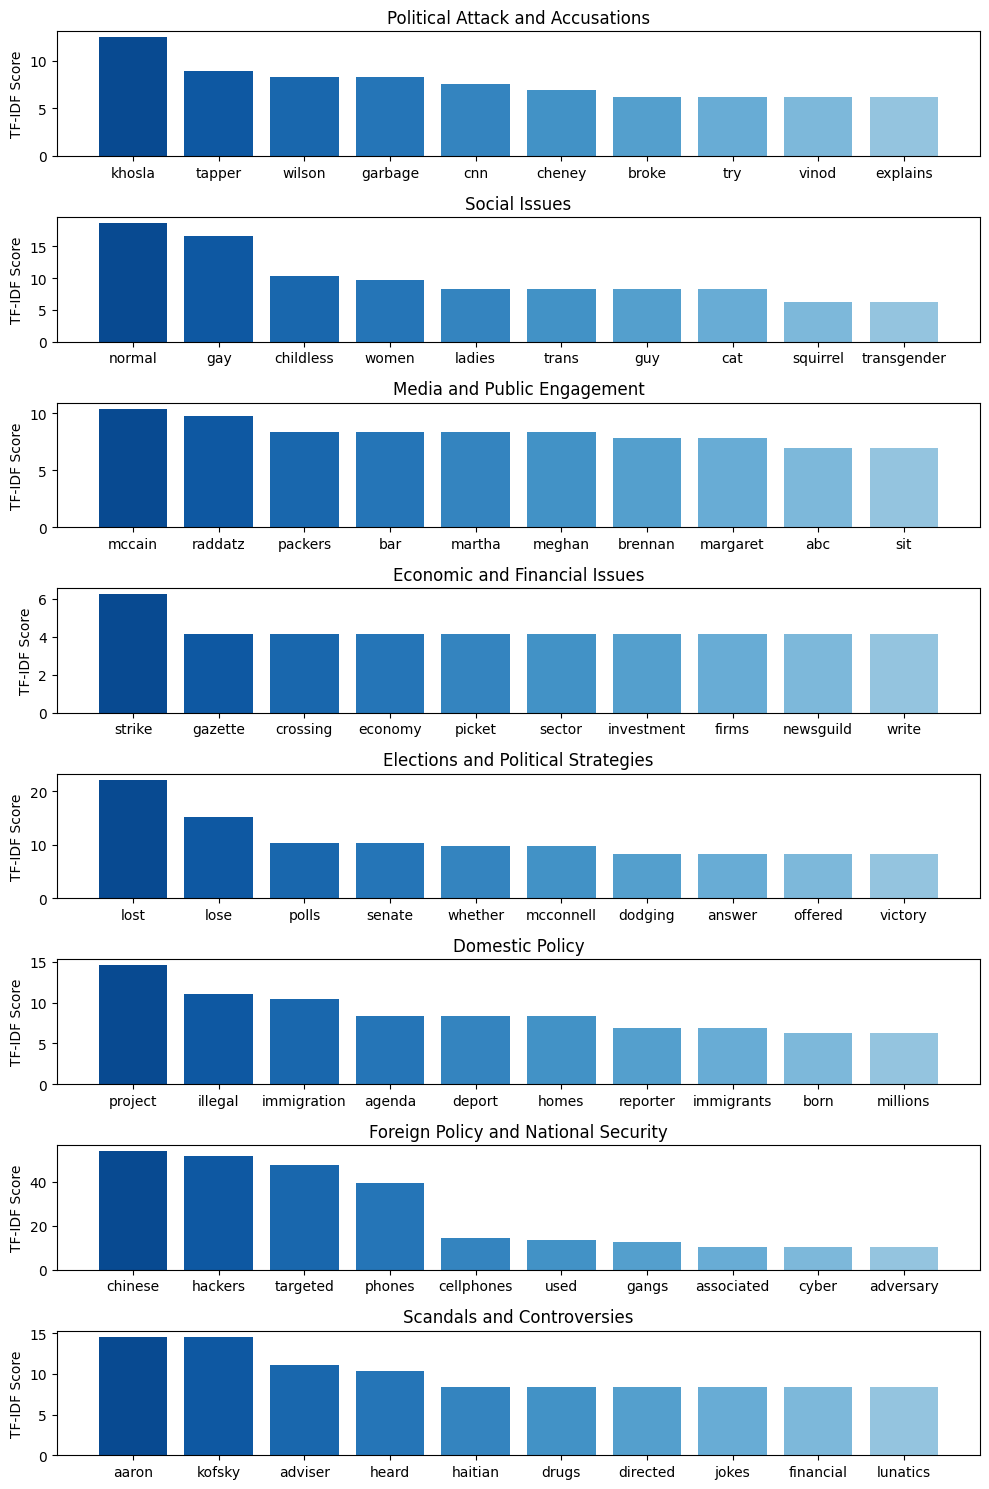

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(8, figsize=(10,15))
colors = cm.Blues(np.linspace(0.4, 0.9, 10)[::-1])

for i, (category, data) in enumerate(tf_idf_dict.items()):
    words = [e[0] for e in data]
    scores = [e[1] for e in data]
    ax[i].bar(words, scores, color=colors)
    ax[i].set_title(category)
    ax[i].set_ylabel('TF-IDF Score')

plt.tight_layout()
plt.show()

In [44]:
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')
df = df[df['topic pass 2'].map(lambda x: type(x) == str)]

In [47]:
df.head()

,source,author,title,description,url,publishedAt,topic pass 1,topic pass 2,negative/neutral/positive
0,Biztoc.com,breakingthenews.net,"JD Vance slams Harris: 'Tomorrow, you're fired'",Republican vice presidential candidate JD Vanc...,https://biztoc.com/x/c4c538f75498736e,2024-11-04T22:53:56Z,Vance criticises Harris,Political Attack and Accusations,neutral
1,Biztoc.com,nbcnews.com,'Feels kind of weird': Vance reflects and look...,"Sen. JD Vance, who says running as Trump's VP ...",https://biztoc.com/x/339813fc9b9bc9be,2024-11-04T22:53:24Z,"social fabric, friends, political differences",Social Issues,neutral
2,NBC News,Henry J. Gomez and Alec Hernández,'Feels kind of weird': Vance reflects and look...,'Feels kind of weird': Vance reflects and look...,https://www.nbcnews.com/politics/2024-election...,2024-11-04T22:15:42Z,"social fabric, friends, political differences",Social Issues,neutral
3,Bleeding Cool News,Ray Flook,Last Week Tonight: HBO Releases John Oliver Se...,"For us, Sunday night's edition of HBO's Last W...",https://bleedingcool.com/tv/last-week-tonight-...,2024-11-04T15:07:08Z,"news shows, anti-Vance sentiment",Media and Public Engagement,negative
4,New York Post,Emily Crane,JD Vance says Trump is ‘fired up’ over death o...,Republican vice presidential candidate JD Vanc...,https://nypost.com/2024/11/04/us-news/jd-vance...,2024-11-04T15:06:04Z,"media events, Peanut",Social Issues,neutral


In [68]:
df['date'] = pd.to_datetime(df['publishedAt']).dt.strftime('%m/%d/%Y')

In [ ]:
negative_mask = df['negative/neutral/positive'] == 'negative'
positive_mask = df['negative/neutral/positive'] == 'positive'
neutral_mask = df['negative/neutral/positive'] == 'neutral'

negative_dates = df[negative_mask]['date'].sort_values()
negative_counts = np.cumsum(negative_dates.value_counts(sort=False).to_numpy())
negative_dates = negative_dates.unique()

positive_dates = df[positive_mask]['date'].sort_values()
positive_counts = np.cumsum(positive_dates.value_counts(sort=False).to_numpy())
positive_dates = positive_dates.unique()

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [101]:
positive_dates, positive_counts

(array(['10/14/2024', '10/15/2024', '10/16/2024', '10/17/2024',
        '10/18/2024', '10/20/2024', '10/21/2024', '10/22/2024',
        '10/23/2024', '10/24/2024', '10/25/2024', '10/26/2024',
        '10/27/2024', '10/28/2024', '10/29/2024', '10/31/2024',
        '11/01/2024', '11/02/2024', '11/03/2024', '11/04/2024'],
       dtype=object),
 array([ 9, 10, 14, 16, 19, 21, 23, 24, 28, 29, 31, 34, 44, 48, 50, 56, 62,
        69, 72, 75]))

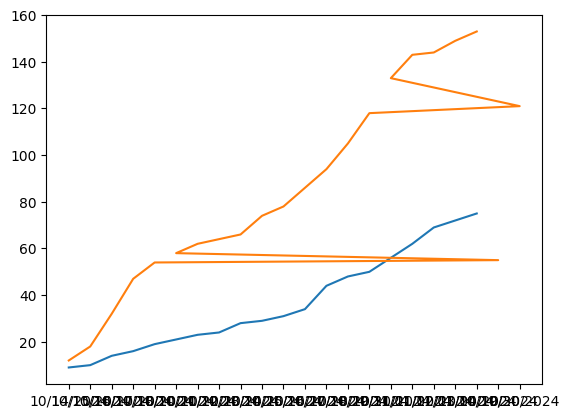

In [105]:
ax = plt.subplot()
ax.plot(positive_dates, positive_counts)
ax.plot(negative_dates, negative_counts)

In [59]:
print(df['negative/neutral/positive'].value_counts().to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
negative/neutral/positive &  \\
\midrule
neutral & 278 \\
negative & 153 \\
positive & 75 \\
\bottomrule
\end{tabular}



In [56]:
counts_df = df.copy()
counts_df['count'] = 1
counts_df = counts_df[['topic pass 2', 'negative/neutral/positive', 'count']]
counts_df.groupby(['topic pass 2', 'negative/neutral/positive']).count()

count
topic pass 2                         negative/neutral/positive       
Domestic Policy                      negative                      20
                                     neutral                       22
                                     positive                       9
Economic and Financial Issues        negative                       7
                                     neutral                        9
                                     positive                       5
Elections and Political Strategies   negative                      27
                                     neutral                       69
                                     positive                      12
Foreign Policy and National Security negative                       1
                                     neutral                       47
                                     positive                       9
Media and Public Engagement          negative                       3
                                     neutral                       44
                                     positive                      19
Political Attack and Accusations     negative                      29
                                     neutral                       37
                                     positive                      12
Scandals and Controversies           negative                      46
                                     neutral                       28
                                     positive                       5
Social Issues                        negative                      20
                                     neutral                       22
                                     positive                       4